In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import scipy.io as sio
from scipy.signal import resample
import os

import numpy as np
import random
import pickle 
from sklearn import preprocessing

%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append('..')


In [129]:
def normalize(quant, minn, maxx):
    a = -1
    b = 1
    t = a + ( quant - minn) * ((b - a) / (maxx - minn))
    return t.astype(np.float32)

In [152]:
class FFIntNet(nn.Module):
    def __init__(self, input_dim=30, output_dim=1, act='tanh'):
        super(FFIntNet, self).__init__()
        self.linear1 = nn.Linear(input_dim, 32, bias=False)
        self.linear2 = nn.Linear(32, 64, bias=False)
        self.linear3 = nn.Linear(64, 32, bias=False)
        self.linear4 = nn.Linear(32, 16, bias=False)
        self.linear5 = nn.Linear(16, output_dim, bias=False)
        self.dropout = nn.Dropout(0.5)
        if act == 'relu':
            self.act = nn.ReLU()
        if act == 'tanh':
            self.act = nn.Tanh()

    def forward(self, x):
        out = self.act(self.linear1(x))
        out = self.act(self.linear2(out))
        out = self.act(self.linear3(out))
        out = self.act(self.linear4(out))
        out = self.linear5(out)
        return out


In [160]:
class RNNNet(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_dim=5, act='relu'):
        super(RNNNet, self).__init__()

        self.rnn = nn.RNN(input_dim, hidden_dim, 1, batch_first=True, nonlinearity=act)
        self.linear1 = nn.Linear(hidden_dim, 10)
        self.linear2 = nn.Linear(10, output_dim)
        if act == 'relu':
            self.act = nn.ReLU()
        if act == 'tanh':
            self.act = nn.Tanh()

    def forward(self, seq):
        out = self.rnn(seq)[0]
        out = self.act(self.linear1(out))
        out = self.linear2(out)
        out = torch.mean(out, dim=1)
        return out

117


In [5]:
fin = open('../../datasets/raw_data_integer.pkl','rb')
dataset = pickle.load(fin)
fin.close()

In [147]:
def get_train_val_samples(dataset, window, stride):
    train_samples = []
    for k in list(dataset.keys())[:8]:
        for i in range(0,dataset[k].shape[1],stride):
            if i + window < dataset[k].shape[1]:
                train_samples.append([k,i,i+window])
    
    val_samples = []
    for k in list(dataset.keys())[8:]:
        for i in range(0,dataset[k].shape[1],stride):
            if i + window < dataset[k].shape[1]:
                val_samples.append([k,i,i+window])
    
    return train_samples, val_samples

In [153]:
train_samples, val_samples = get_train_val_samples(dataset, 10, 1)
print ('train samples : ',len(train_samples))
print ('val samples : ',len(val_samples))

train samples :  194663
val samples :  102569


In [161]:
# net =  FFIntNet(act='relu').cuda()
net = RNNNet(3, 1, act='tanh').cuda()
print (sum(p.numel() for p in net.parameters()))
# inp = torch.randn(1024,15).cuda()
# net(inp).size()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

121


In [172]:
for epoch in range(100):
    random.shuffle(train_samples)
    
    train_losses = []
    val_losses = []
    
    net.train()
    
    for i in range(0,len(train_samples),1024):
        inp = []
        out = []
        for j in range(i,i+256):
            if j < len(train_samples):
                v1 = dataset[train_samples[j][0]][0,train_samples[j][1]:train_samples[j][2]]
                v2 = dataset[train_samples[j][0]][1,train_samples[j][1]:train_samples[j][2]]
                s = dataset[train_samples[j][0]][2,train_samples[j][1]:train_samples[j][2]]
                
                v1 = normalize(v1, -2**15, 2**15)
                v2 = normalize(v2, -2**15, 2**15)
                s = normalize(s, -2**15, 2**15)
                
                c1 = dataset[train_samples[j][0]][3,train_samples[j][1]+5]
                c2 = dataset[train_samples[j][0]][4,train_samples[j][1]+5]
                t = dataset[train_samples[j][0]][5,train_samples[j][1]+5]
                
                c1 = normalize(c1, -2**12, 2**12)
                c2 = normalize(c2, -2**12, 2**12)
                t = normalize(t, -2**10, 2**10)
                
                inp.append([v1,v2,s])
                out.append([t])
        inp = torch.from_numpy(np.asarray(inp)).cuda().float()
        out = torch.from_numpy(np.asarray(out)).cuda().float()
        
#         inp = inp.view(inp.size()[0], -1)
        inp = inp.permute(0,2,1)
#         print (inp.size())
        pred = net(inp)
        
        out = out.view(out.size()[0], -1)
        
#         print (pred.size(),out.size())
        loss = criterion(pred, out)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
    train_loss = np.mean(train_losses)
    
    net.eval()
    
    for i in range(0,len(val_samples),1024):
        inp = []
        out = []
        for j in range(i,i+256):
            if j < len(val_samples):
                v1 = dataset[val_samples[j][0]][0,val_samples[j][1]:val_samples[j][2]]
                v2 = dataset[val_samples[j][0]][1,val_samples[j][1]:val_samples[j][2]]
                s = dataset[val_samples[j][0]][2,val_samples[j][1]:val_samples[j][2]]
                
                v1 = normalize(v1, -2**15, 2**15)
                v2 = normalize(v2, -2**15, 2**15)
                s = normalize(s, -2**15, 2**15)
                
                c1 = dataset[val_samples[j][0]][3,val_samples[j][1]+5]
                c2 = dataset[val_samples[j][0]][4,val_samples[j][1]+5]
                t = dataset[val_samples[j][0]][5,val_samples[j][1]+5]
                
                c1 = normalize(c1, -2**12, 2**12)
                c2 = normalize(c2, -2**12, 2**12)
                t = normalize(t, -2**10, 2**10)
                
                inp.append([v1,v2,s])
                out.append([t])
                
        inp = torch.from_numpy(np.asarray(inp)).cuda().float()
        out = torch.from_numpy(np.asarray(out)).cuda().float()
        
#         inp = inp.view(inp.size()[0], -1)
        inp = inp.permute(0,2,1)
        pred = net(inp)
        
        out = out.view(out.size()[0], -1)
        
#         print (out.size(), pred.size())
        loss = criterion(pred, out)
        
        val_losses.append(loss.item())
        
    val_loss = np.mean(val_losses)
    
    print ('epoch : ', epoch, 'train loss : ', train_loss, ' val loss : ', val_loss)

epoch :  0 train loss :  1.5690022906707843  val loss :  2.135553885089916
epoch :  1 train loss :  1.5718193428678662  val loss :  2.3597779654219715
epoch :  2 train loss :  1.5552249990832743  val loss :  2.0652490363705276
epoch :  3 train loss :  1.5705146901894613  val loss :  2.0945972546884364
epoch :  4 train loss :  1.5749958263641877  val loss :  2.2315658693958826
epoch :  5 train loss :  1.5700783236488622  val loss :  1.973316286372408
epoch :  6 train loss :  1.5726119136310996  val loss :  2.172945091619743
epoch :  7 train loss :  1.5720556031971078  val loss :  2.1294874801660084
epoch :  8 train loss :  1.5684498723264764  val loss :  1.906238110422498


KeyboardInterrupt: 

In [182]:
c1_true = []
c2_true = []
t_true = []

c1_pred = []
c2_pred = []
t_pred = []

val_data = dataset['LM60_TroqueSteps.mat']
for i in range(0,val_data.shape[1],1):
    if i + 5< val_data.shape[1]:
        v1 = val_data[0,i:i+10]
        v2 = val_data[1,i:i+10]
        s = val_data[2,i:i+10]

        v1 = normalize(v1, -2**15, 2**15)
        v2 = normalize(v2, -2**15, 2**15)
        s = normalize(s, -2**15, 2**15)

        c1 = val_data[3,i+5]
        c2 = val_data[4,i+5]
        t = val_data[5,i+5]

        c1 = normalize(c1, -2**12, 2**12)
        c2 = normalize(c2, -2**12, 2**12)
        t = normalize(t, -2**10, 2**10)
        
        c1_true.append(c1)
        c2_true.append(c2)
        t_true.append(t)
        
        inp = [v1,v2,s]
        
        inp = torch.from_numpy(np.asarray([inp])).cuda().float().permute(0,2,1)
        
#         print (inp.size())
        pred = net(inp).data.cpu().numpy()
        
#         c1_pred.append(pred[0,0])
#         c2_pred.append(pred[1,0])
        t_pred.append(pred[0,0])

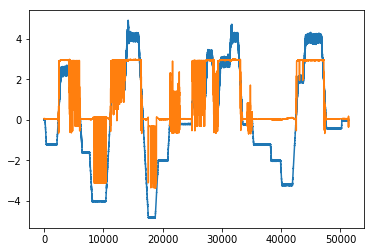

In [181]:
plt.plot(t_true)
plt.plot(t_pred)

In [34]:
dataset.keys()

dict_keys(['LM10.mat', 'LM30.mat', 'LM60_TroqueSteps.mat', 'LM50.mat', 'NoLM.mat', 'NoLM_SpeedVariations.mat', 'LM68.mat', 'NoLM_SpeedVariations2.mat', 'LM20_TorqueSteps.mat', 'LM45_TorqueSteps.mat'])